# Train lstm4 model for phishing URL detection

## Imports

In [1]:
import numpy as np
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

import tensorflow_text as tf_text

In [2]:
dataset_dir = pathlib.Path("../URL_dataset/")
model_dir = pathlib.Path('../URL_models/')
checkpoint_dir = pathlib.Path('../URL_checkpoints/')

In [3]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-09-11_12;38;14.218039


In [4]:
os.listdir(dataset_dir)

['benign', 'phishing']

## Params

In [5]:
model_name = "lstm4"
batch_size = 32
rest_split_ratio = 0.2
test_split_ratio = 0.2

unicode_max = 1114111

## Load dataset

In [6]:
train_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 36275 files for training.


In [7]:
rest_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 9068 files for validation.


In [8]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

284


In [9]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [10]:
train_ds.cardinality().numpy()

1134

In [11]:
val_ds.cardinality().numpy()

228

In [12]:
test_ds.cardinality().numpy()

56

In [13]:
class_names = train_ds.class_names

In [14]:
class_names

['benign', 'phishing']

## Explore dataset

In [15]:
b = train_ds.take(1)

In [16]:
b

<TakeDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float32)>

In [17]:
for batch in b:
    for url, label in zip(batch[0].numpy(), batch[1].numpy()):
        print(url, class_names[int(label[0])])

b'http://online.citi.com.3qf2k0ckn2o4an2mjfrduvskrwvgn4.gateway5.com/images/online.php' phishing
b'http://www.terapias-spa.com/login.mail.com.us.gooogle.sess8723203823-secure87367282664783.user-neo.y7m1g6.com.launch.secure.sess734894.11gbfree.zzhjhbbxs.sec9711102nghd7752uewjknbghc.com.den26utm.safety.sess884722122/' phishing
b'http://momoshop.com.tw/category/LgrpCategory.jsp?l_code=2102400000&Area=tooth&FTOOTH=21&mdiv=1000900000-bt_5_023_03&ctype=B' benign
b'http://censor.net.ua/resonance/330659/aleksandr_yaroslavskiyi_kogda_klub_vozglavlyaet_kloun_vse_mojet_byt' benign
b'http://irecommend.ru/content/koftochka-aliexpress-free-shipping-2015-male-child-letter-urban-cotton-white-hood-sweatshirt' benign
b'http://appleid.apple.co.uk.cgi-bin.webobjects.myappleid.woa.verify2.eu-id3.net/identify-customer=r3cZu4QGsRB0bu4pyomoXlEZkQrwQUYKbPz7Ye2MeaiqBiLntI6nwEXLuMkoxYikZcRPrRR5faT6rYz726zg9a7ePsToDpxRa8xj/' phishing
b'http://1337x.to/torrent/1160325/White-Noise-Meditation-10-Hz-Alpha-Ocean-Wave-

## Vectorize

Cannot use the vectorization layers since it is not supported in TFJS; we can rather have a custom tokenizer which can be then exported as json then loaded in JS

In [18]:
tokenizer = tf_text.UnicodeCharTokenizer()

In [19]:
train_ds = train_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
val_ds = val_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
test_ds = test_ds.map(lambda x, y: (tokenizer.tokenize(x), y))

## Tune dataset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(256).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [21]:
num_classes = 2
embedding_dim = 16
lstm1_units = 256
lstm2_units = 512
dropout_prob1 = 0.2
dropout_prob2 = 0.1
reg_rate1 = 0.001
reg_rate2 = 0.001

model = Sequential([
    layers.Embedding(unicode_max, embedding_dim),
    layers.LSTM(
        lstm1_units,
        kernel_regularizer=regularizers.L1L2(reg_rate1, reg_rate2),
#         recurrent_regularizer=regularizers.L1L2(reg_rate1),
#         bias_regularizer=regularizers.L1L2(reg_rate1),
#         activity_regularizer=regularizers.L1L2(reg_rate1),
        dropout=dropout_prob1,
        return_sequences=True
    ),
    layers.LSTM(
        lstm2_units,
        kernel_regularizer=regularizers.L1L2(reg_rate1, reg_rate2),
#         recurrent_regularizer=regularizers.L1L2(reg_rate1),
#         bias_regularizer=regularizers.L1L2(reg_rate1),
#         activity_regularizer=regularizers.L1L2(reg_rate1,
        dropout=dropout_prob2,
    ),
    layers.Dense(num_classes-1)
])

In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          17825776  
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         279552    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 19,680,753
Trainable params: 19,680,753
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Training

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [25]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15


C:\Users\fracta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1134/1134 [==============================] - 3478s 3s/step - loss: 0.8542 - accuracy: 0.7869 - val_loss: 0.5797 - val_accuracy: 0.7871

Epoch 00001: val_loss improved from inf to 0.57973, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.7871_e1


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.7871_e1\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.7871_e1\assets


Epoch 2/15
1134/1134 [==============================] - 3520s 3s/step - loss: 0.4909 - accuracy: 0.8379 - val_loss: 0.3437 - val_accuracy: 0.9109

Epoch 00002: val_loss improved from 0.57973 to 0.34369, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9109_e2


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9109_e2\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9109_e2\assets


Epoch 3/15
1134/1134 [==============================] - 3430s 3s/step - loss: 0.3613 - accuracy: 0.9045 - val_loss: 0.3767 - val_accuracy: 0.8927

Epoch 00003: val_loss did not improve from 0.34369
Epoch 4/15
1134/1134 [==============================] - 3389s 3s/step - loss: 0.3546 - accuracy: 0.9072 - val_loss: 0.3427 - val_accuracy: 0.9130

Epoch 00004: val_loss improved from 0.34369 to 0.34271, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9130_e4


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9130_e4\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9130_e4\assets


Epoch 5/15
1134/1134 [==============================] - 3507s 3s/step - loss: 0.3535 - accuracy: 0.9080 - val_loss: 0.3451 - val_accuracy: 0.9136

Epoch 00005: val_loss did not improve from 0.34271
Epoch 6/15
1134/1134 [==============================] - 3397s 3s/step - loss: 0.3425 - accuracy: 0.9102 - val_loss: 0.3321 - val_accuracy: 0.9136

Epoch 00006: val_loss improved from 0.34271 to 0.33215, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9136_e6


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9136_e6\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9136_e6\assets


Epoch 7/15
1134/1134 [==============================] - 3405s 3s/step - loss: 0.3363 - accuracy: 0.9113 - val_loss: 0.3353 - val_accuracy: 0.9130

Epoch 00007: val_loss did not improve from 0.33215
Epoch 8/15
1134/1134 [==============================] - 3399s 3s/step - loss: 0.3371 - accuracy: 0.9105 - val_loss: 0.3265 - val_accuracy: 0.9164

Epoch 00008: val_loss improved from 0.33215 to 0.32648, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9164_e8


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9164_e8\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9164_e8\assets


Epoch 9/15
1134/1134 [==============================] - 3394s 3s/step - loss: 0.3362 - accuracy: 0.9113 - val_loss: 0.3793 - val_accuracy: 0.8927

Epoch 00009: val_loss did not improve from 0.32648
Epoch 10/15
1134/1134 [==============================] - 3383s 3s/step - loss: 0.3375 - accuracy: 0.9112 - val_loss: 0.3274 - val_accuracy: 0.9141

Epoch 00010: val_loss did not improve from 0.32648
Epoch 11/15
1134/1134 [==============================] - 3373s 3s/step - loss: 0.3619 - accuracy: 0.9089 - val_loss: 0.3370 - val_accuracy: 0.9141

Epoch 00011: val_loss did not improve from 0.32648
Epoch 12/15
1134/1134 [==============================] - 3380s 3s/step - loss: 0.3358 - accuracy: 0.9114 - val_loss: 0.3262 - val_accuracy: 0.9141

Epoch 00012: val_loss improved from 0.32648 to 0.32615, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e12


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e12\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e12\assets


Epoch 13/15
1134/1134 [==============================] - 3392s 3s/step - loss: 0.3303 - accuracy: 0.9120 - val_loss: 0.3241 - val_accuracy: 0.9141

Epoch 00013: val_loss improved from 0.32615 to 0.32410, saving model to ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e13


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e13\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-11_12;38;14.218039_lstm4_valacc0.9141_e13\assets


Epoch 14/15
1134/1134 [==============================] - 3427s 3s/step - loss: 0.3741 - accuracy: 0.9051 - val_loss: 0.3876 - val_accuracy: 0.9109

Epoch 00014: val_loss did not improve from 0.32410
Epoch 15/15
1134/1134 [==============================] - 3407s 3s/step - loss: 0.3462 - accuracy: 0.9111 - val_loss: 0.3309 - val_accuracy: 0.9136

Epoch 00015: val_loss did not improve from 0.32410


## Save model

In [26]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\URL_models\2021-09-11_12;38;14.218039_lstm4_valacc0.9136_e15_b32.tf\assets


INFO:tensorflow:Assets written to: ..\URL_models\2021-09-11_12;38;14.218039_lstm4_valacc0.9136_e15_b32.tf\assets


## Load model

In [27]:
# change filename to the model you want to load
model_filename = "2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9"
model2 = keras.models.load_model(
    checkpoint_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [28]:
history.history

{'loss': [0.8541692495346069,
  0.49090033769607544,
  0.36132362484931946,
  0.3546302616596222,
  0.3535425066947937,
  0.34247300028800964,
  0.3362564444541931,
  0.33713021874427795,
  0.3361663818359375,
  0.3375404477119446,
  0.3619243800640106,
  0.3358101546764374,
  0.3302987515926361,
  0.37408339977264404,
  0.3462353050708771],
 'accuracy': [0.7868504524230957,
  0.8379324674606323,
  0.9044796824455261,
  0.9071536660194397,
  0.9079806804656982,
  0.9101585149765015,
  0.9112887382507324,
  0.9104617238044739,
  0.9112612009048462,
  0.9112336039543152,
  0.9089455604553223,
  0.9113714694976807,
  0.9120054841041565,
  0.9050861597061157,
  0.9111233353614807],
 'val_loss': [0.5797262191772461,
  0.3436949849128723,
  0.37665998935699463,
  0.34271469712257385,
  0.34511393308639526,
  0.3321484327316284,
  0.3353351056575775,
  0.3264833986759186,
  0.37932395935058594,
  0.32739755511283875,
  0.3369862735271454,
  0.32615217566490173,
  0.3240971565246582,
  0.38761

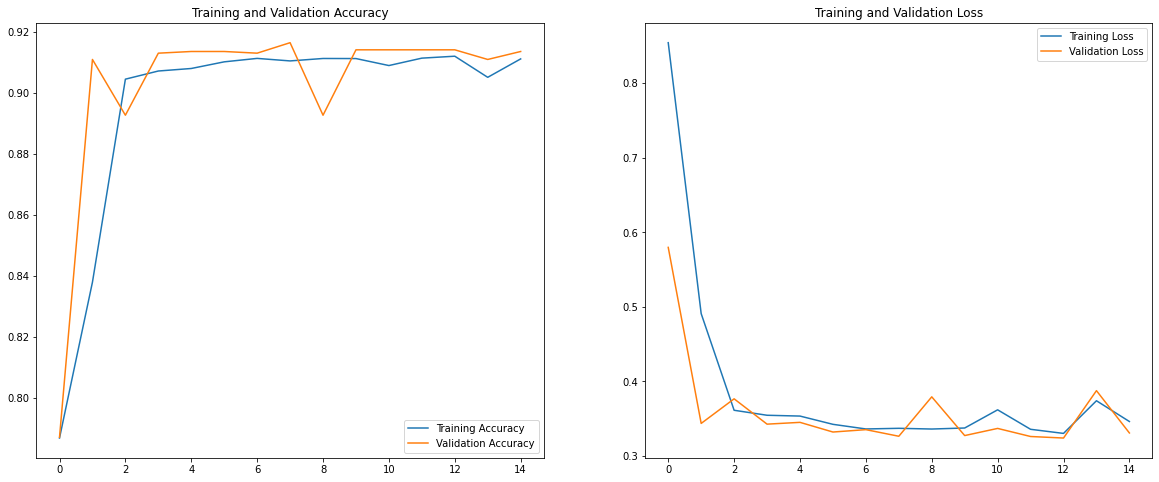

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [30]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

228/228 [==============================] - 60s 262ms/step - loss: 0.3309 - accuracy: 0.9136
val loss, val acc: [0.3308982253074646, 0.913551390171051]


In [31]:
val_results = model2.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

228/228 [==============================] - 61s 267ms/step - loss: 0.1130 - accuracy: 0.9736
val loss, val acc: [0.11301612854003906, 0.9736118912696838]


In [32]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


56/56 [==============================] - 16s 274ms/step - loss: 0.3614 - accuracy: 0.8979
test loss, test acc: [0.3613634407520294, 0.8978794813156128]


In [33]:
results = model2.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


56/56 [==============================] - 14s 258ms/step - loss: 0.1307 - accuracy: 0.9738
test loss, test acc: [0.13069000840187073, 0.9737723469734192]


In [34]:
test_ds.cardinality().numpy()

56